In [1]:
import json
import io
import tensorflow as tf
from google.colab import drive
from colabtools import drive
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping



import tensorflow as tf


import io

In [2]:
tf.__version__

'2.17.0'

In [3]:
from colabtools import drive
import io

raw = drive.LoadFile(file_id='1wkq6whn9zCiY5-9CRCxFhkoO36YVKX2A')
b = io.BytesIO(raw)
final_data = pd.read_csv(b,keep_default_na=False).dropna(subset=['combined_terrain_aspects','combined_terrain_elevations'], how="any")
final_data

Beginning OAuth2 authorization process ...
Authentication successful.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

date_time  ... problem_discussion_2_bert_all_case_emb_767
0     2021-04-17  ...                                   0.336898
1     2021-04-17  ...                                   0.336898
2     2021-04-17  ...                                   0.336898
3     2021-04-17  ...                                   0.336898
4     2021-04-17  ...                                   0.336898
...          ...  ...                                        ...
6387  2022-11-29  ...                                   0.336898
6388  2022-11-29  ...                                   0.336898
6389  2022-11-29  ...                                   0.336898
6390  2022-11-29  ...                                   0.336898
6391  2022-11-29  ...                                   0.336898

[6392 rows x 3159 columns]

In [4]:
final_data.shape

(6392, 3159)

In [5]:
from google3.pyglib import gfile
import json


raw = drive.LoadFile(file_id='1RVQmtKDwxveXtHRvlpYjZb3dlRlnZEl_')

with io.BytesIO(raw) as f:
  feature_dict = json.load(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
feature_dict.keys()

dict_keys(['cat_vars_num', 'cat_vars_str', 'num_vars', 'num_vars_norm'])

# Model_1 with random test vs. validation

In [7]:
final_data['target'] = final_data['is_avy_obs'].replace({'Yes': 1, 'No': 0})
dataframe = final_data.drop(columns=['date_time','is_avy_obs'])

dataframe.head(2)

above_treeline_cat  ...  target
0                 2.0  ...       0
1                 2.0  ...       0

[2 rows x 3158 columns]

In [8]:
from sklearn.model_selection import train_test_split
cutoff_date = '2022-06-01'
train_r = final_data[final_data['date_time'] < cutoff_date].drop(columns=['date_time', 'is_avy_obs'])
train_r, val_r = train_test_split(train_r,  test_size=0.2, random_state=42)
test_r = final_data[final_data['date_time'] >= cutoff_date].drop(columns=['date_time', 'is_avy_obs'])


print(train_r.shape)
print(val_r.shape)
print(test_r.shape)


(3124, 3158)
(782, 3158)
(2486, 3158)


In [ ]:
test_r[feature_dict['num_vars']].head(2)

bottom_line_bert_all_case_emb_0  ...  problem_discussion_2_bert_all_case_emb_767
3906                        -0.402135  ...                                    0.336898
3907                        -0.402135  ...                                    0.336898

[2 rows x 3072 columns]

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.tolist() for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [10]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [11]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [12]:
batch_size = 256
train_ds_r = df_to_dataset(train_r, batch_size=batch_size)
val_ds_r = df_to_dataset(val_r, shuffle=False, batch_size=batch_size)
test_ds_r = df_to_dataset(test_r, shuffle=False, batch_size=batch_size)

In [13]:
all_inputs_num_vars_norm = []
encoded_features_num_vars_norm = []

# Numerical features.
for header in feature_dict["num_vars_norm"]:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds_r)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs_num_vars_norm.append(numeric_col)
  encoded_features_num_vars_norm.append(encoded_numeric_col)

In [14]:
all_inputs_cat_vars_str = []
encoded_features_cat_vars_str= []

for header in feature_dict["cat_vars_str"]:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds_r,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs_cat_vars_str.append(categorical_col)
  encoded_features_cat_vars_str.append(encoded_categorical_col)

In [15]:
all_inputs_cat_vars_num = []
encoded_features_cat_vars_num= []


for header in feature_dict["cat_vars_num"]:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds_r,
                                               dtype='int32',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs_cat_vars_num.append(categorical_col)
  encoded_features_cat_vars_num.append(encoded_categorical_col)

In [ ]:
# all_inputs_num_vars = []
# encoded_features_num_vars= []

# bert_col = tf.keras.Input(shape=(len(feature_dict['num_vars']), ))

# all_inputs_num_vars.append(bert_col)
# encoded_features_num_vars.append(bert_col)

In [16]:
all_inputs_num_vars = []
encoded_features_num_vars= []

for num_var in feature_dict['num_vars']:
    input_layer = tf.keras.Input(shape=(1,), name=num_var)
    all_inputs_num_vars.append(input_layer)
    encoded_features_num_vars.append(input_layer)

In [17]:
encoded_features = encoded_features_num_vars_norm + encoded_features_cat_vars_str + encoded_features_cat_vars_num + encoded_features_num_vars
all_inputs = all_inputs_num_vars_norm + all_inputs_cat_vars_str + all_inputs_cat_vars_num + all_inputs_num_vars

# Model 1

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_ds_r,
          validation_data=val_ds_r,
          epochs=30,  # You can set the number of epochs based on your requirements
          callbacks=[early_stopping])

Epoch 1/30
13/13 [==============================] - 7s 330ms/step - loss: 0.2746 - precision_16: 0.7037 - recall_16: 0.1152 - val_loss: 0.3005 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 2/30
13/13 [==============================] - 6s 319ms/step - loss: 0.2832 - precision_16: 0.5349 - recall_16: 0.2091 - val_loss: 0.3017 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 3/30
13/13 [==============================] - 6s 323ms/step - loss: 0.2735 - precision_16: 0.7303 - recall_16: 0.1970 - val_loss: 0.2888 - val_precision_16: 0.6111 - val_recall_16: 0.2619
Epoch 4/30
13/13 [==============================] - 6s 317ms/step - loss: 0.2696 - precision_16: 0.6209 - recall_16: 0.2879 - val_loss: 0.2855 - val_precision_16: 0.6400 - val_recall_16: 0.1905
Epoch 5/30
13/13 [==============================] - 6s 321ms/step - loss: 0.2677 - precision_16: 0.6667 - recall_16: 0.1273 - val_loss: 0.2830 - val_precision_16: 0.5789 - val_recall_16: 0.2619
Epoch 6/30
13/

In [ ]:
model.evaluate(test_ds_r)


10/10 [==============================] - 5s 451ms/step - loss: 0.5522 - precision_16: 0.6296 - recall_16: 0.2176


[0.5521721243858337, 0.6296296119689941, 0.21755027770996094]

In [ ]:
model.predict(test_ds_r)

10/10 [==============================] - 5s 446ms/step


array([[0.0011701 ],
       [0.0009948 ],
       [0.00170834],
       ...,
       [0.00784246],
       [0.00991118],
       [0.00843744]], dtype=float32)

4/4 [==============================] - 2s 345ms/step


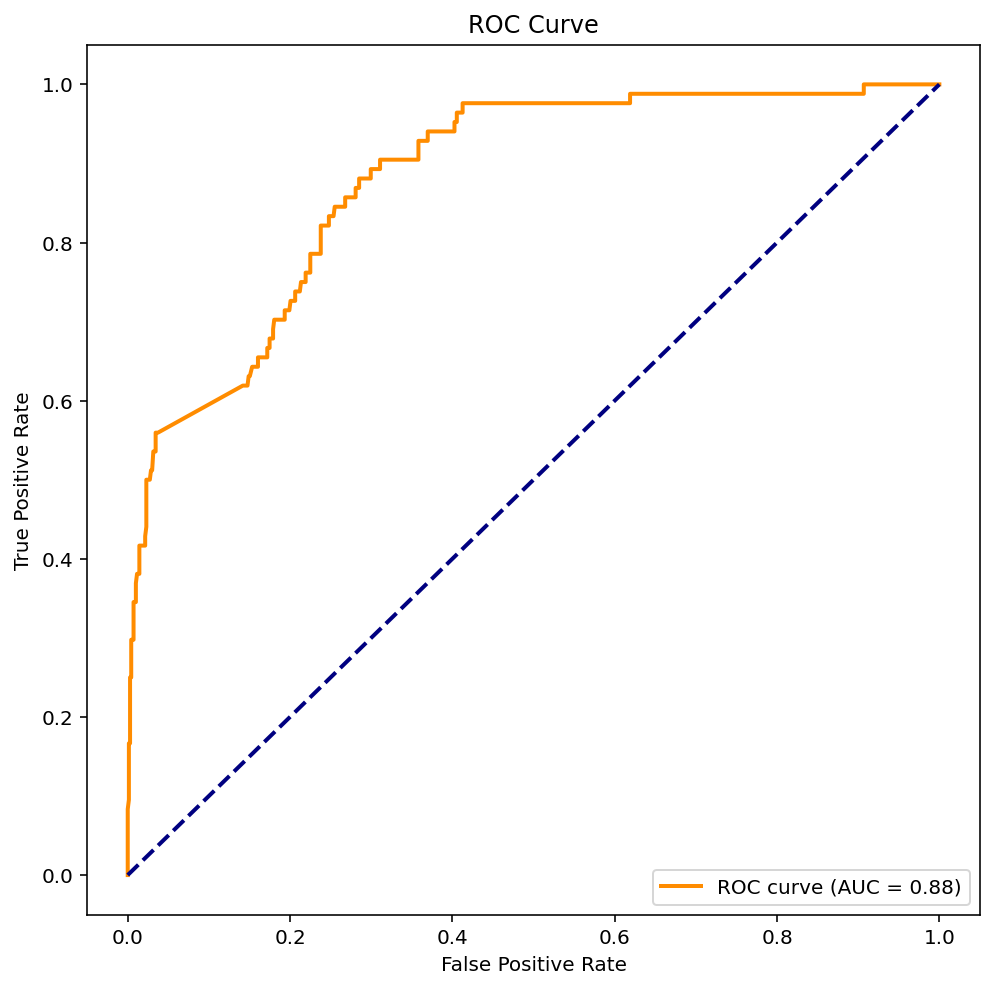

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


y_val_true = []
for x, y in val_ds_r:
    y_val_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_val_true = np.array(y_val_true)
y_val_prob = model.predict(val_ds_r)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
hisotry = model.fit(train_ds_r,
          validation_data=val_ds_r,
          epochs=40,  # You can set the number of epochs based on your requirements
          callbacks=[early_stopping])

Epoch 1/40


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 40s 1s/step - loss: 0.2348 - precision_17: 0.7407 - recall_17: 0.2424 - val_loss: 0.2747 - val_precision_17: 0.9231 - val_recall_17: 0.1429
Epoch 2/40
13/13 [==============================] - 7s 340ms/step - loss: 0.2360 - precision_17: 0.7674 - recall_17: 0.2000 - val_loss: 0.2615 - val_precision_17: 0.7174 - val_recall_17: 0.3929
Epoch 3/40
13/13 [==============================] - 7s 343ms/step - loss: 0.2365 - precision_17: 0.6165 - recall_17: 0.2485 - val_loss: 0.2526 - val_precision_17: 0.9000 - val_recall_17: 0.2143
Epoch 4/40
13/13 [==============================] - 7s 344ms/step - loss: 0.2335 - precision_17: 0.7849 - recall_17: 0.2212 - val_loss: 0.2522 - val_precision_17: 0.8929 - val_recall_17: 0.2976
Epoch 5/40
13/13 [==============================] - 7s 373ms/step - loss: 0.2264 - precision_17: 0.7007 - recall_17: 0.2909 - val_loss: 0.2467 - val_precision_17: 0.6027 - val_recall_17: 0.5238
Epoch 6/40
13/13 [=========================

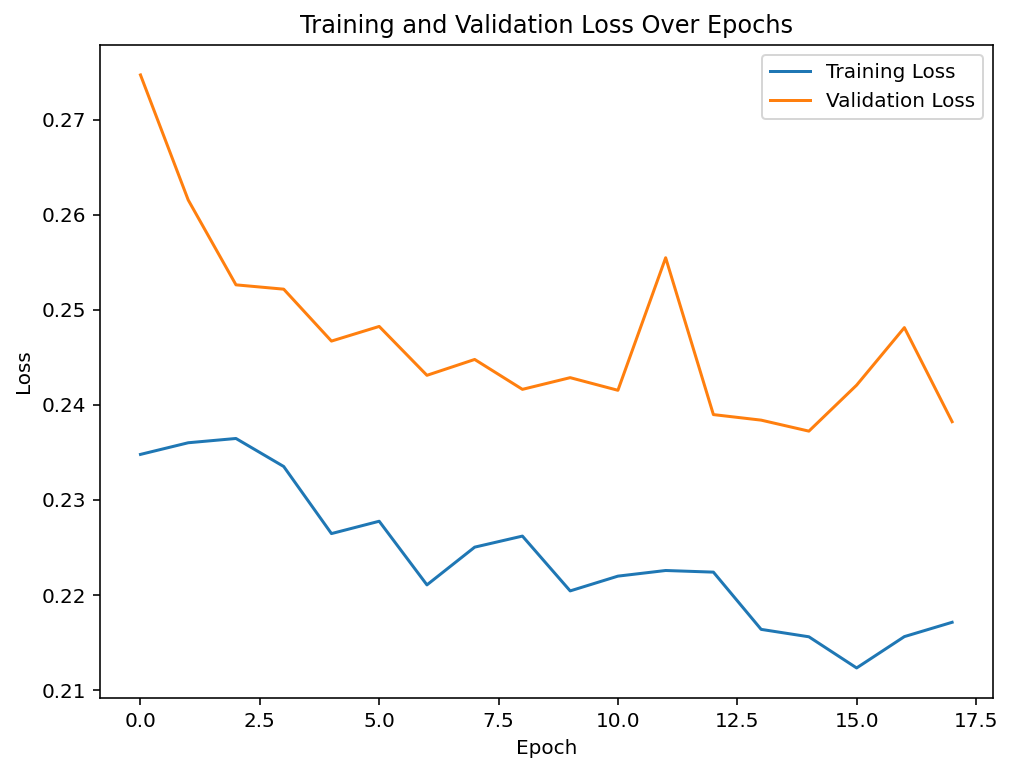

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(hisotry.history['loss'], label='Training Loss')
plt.plot(hisotry.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Model 2 - Try regularization techniques like L1/L2 or dropout

In [18]:
# kernel_regularizer=tf.keras.regularizers.l2(0.01) is added to the dense layer,
# providing L2 regularization with a regularization strength of 0.01.
all_features = tf.keras.layers.concatenate(encoded_features)
# x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
hisotry = model.fit(train_ds_r,
          validation_data=val_ds_r,
          epochs=40,  # You can set the number of epochs based on your requirements
          callbacks=[early_stopping])

Epoch 1/40


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 32s 1s/step - loss: 1.1575 - precision: 0.1457 - recall: 0.1333 - val_loss: 0.8752 - val_precision: 0.5600 - val_recall: 0.1667
Epoch 2/40
13/13 [==============================] - 6s 291ms/step - loss: 0.8437 - precision: 0.3333 - recall: 0.0606 - val_loss: 0.7718 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 6s 288ms/step - loss: 0.7393 - precision: 0.3333 - recall: 0.0212 - val_loss: 0.6915 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 6s 292ms/step - loss: 0.6590 - precision: 0.4839 - recall: 0.0455 - val_loss: 0.6317 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 6s 337ms/step - loss: 0.6145 - precision: 0.5789 - recall: 0.0333 - val_loss: 0.5853 - val_precision: 1.0000 - val_recall: 0.0595
Epoch 6/40
13/13 [==============================] - 6s 291ms/step - loss: 0.567

In [20]:
model.evaluate(test_ds_r)

10/10 [==============================] - 4s 332ms/step - loss: 0.5316 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.5316486954689026, 0.0, 0.0]

4/4 [==============================] - 12s 237ms/step


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


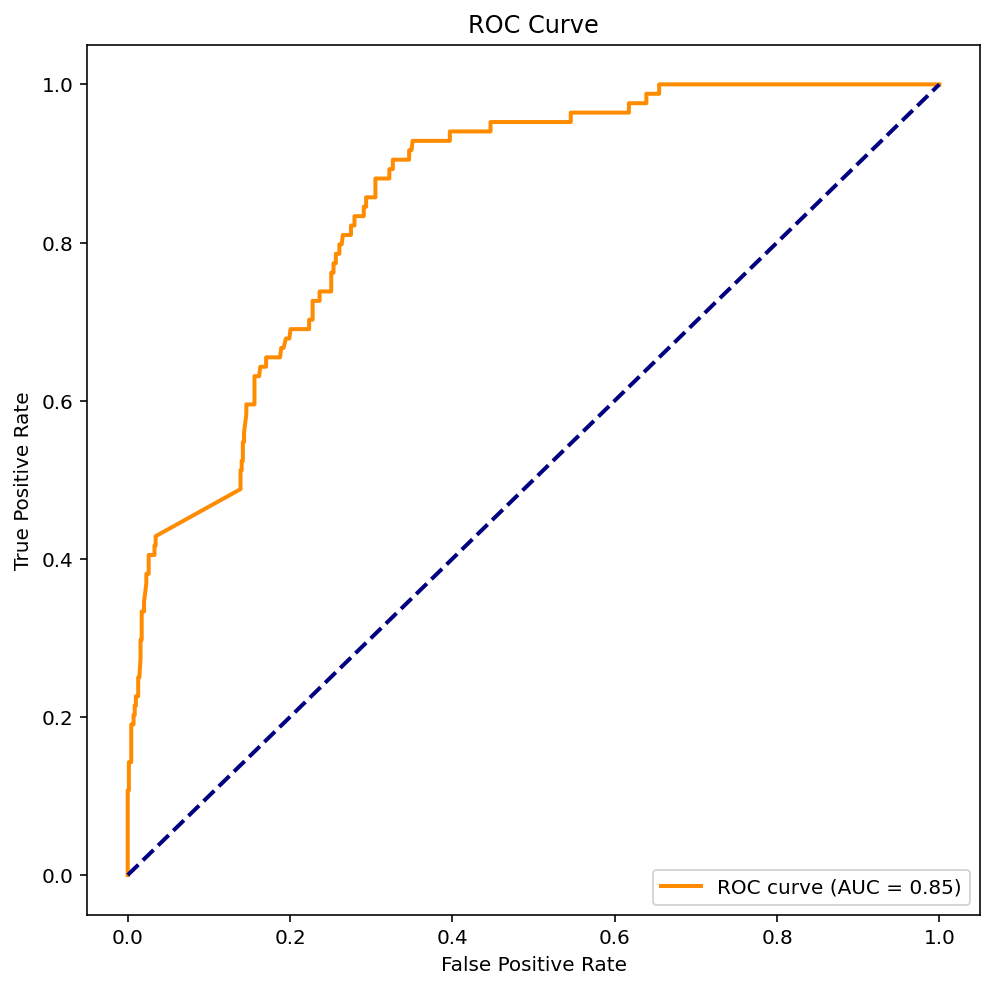

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


y_val_true = []
for x, y in val_ds_r:
    y_val_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_val_true = np.array(y_val_true)
y_val_prob = model.predict(val_ds_r)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


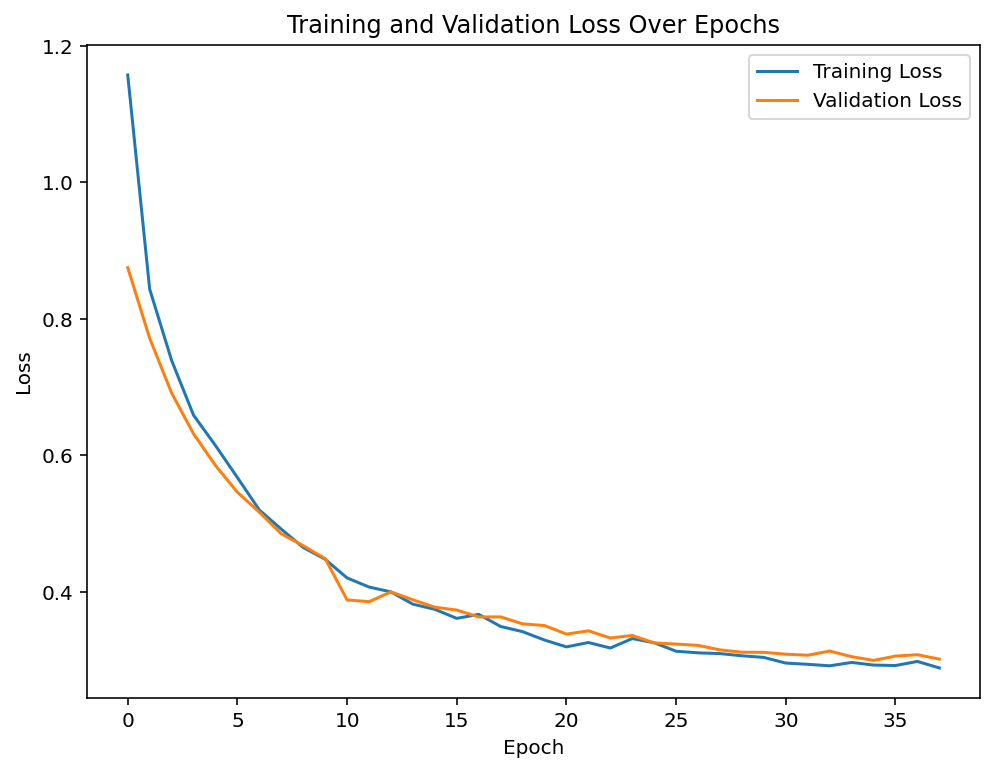

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(hisotry.history['loss'], label='Training Loss')
plt.plot(hisotry.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [38]:
tf.keras.models.save_model(model, "tf_rand_val_nn_v3")

In [39]:
!zip -r tf_rand_val_nn_v3.zip tf_rand_val_nn_v3


  adding: tf_rand_val_nn_v3/ (stored 0%)
  adding: tf_rand_val_nn_v3/saved_model.pb (deflated 93%)
  adding: tf_rand_val_nn_v3/fingerprint.pb (stored 0%)
  adding: tf_rand_val_nn_v3/keras_metadata.pb (deflated 97%)
  adding: tf_rand_val_nn_v3/assets/ (stored 0%)
  adding: tf_rand_val_nn_v3/variables/ (stored 0%)
  adding: tf_rand_val_nn_v3/variables/variables.data-00000-of-00001 (deflated 16%)
  adding: tf_rand_val_nn_v3/variables/variables.index (deflated 23%)


In [40]:
%download_file tf_rand_val_nn_v3.zip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model 2 evaluation

4/4 [==============================] - 1s 276ms/step


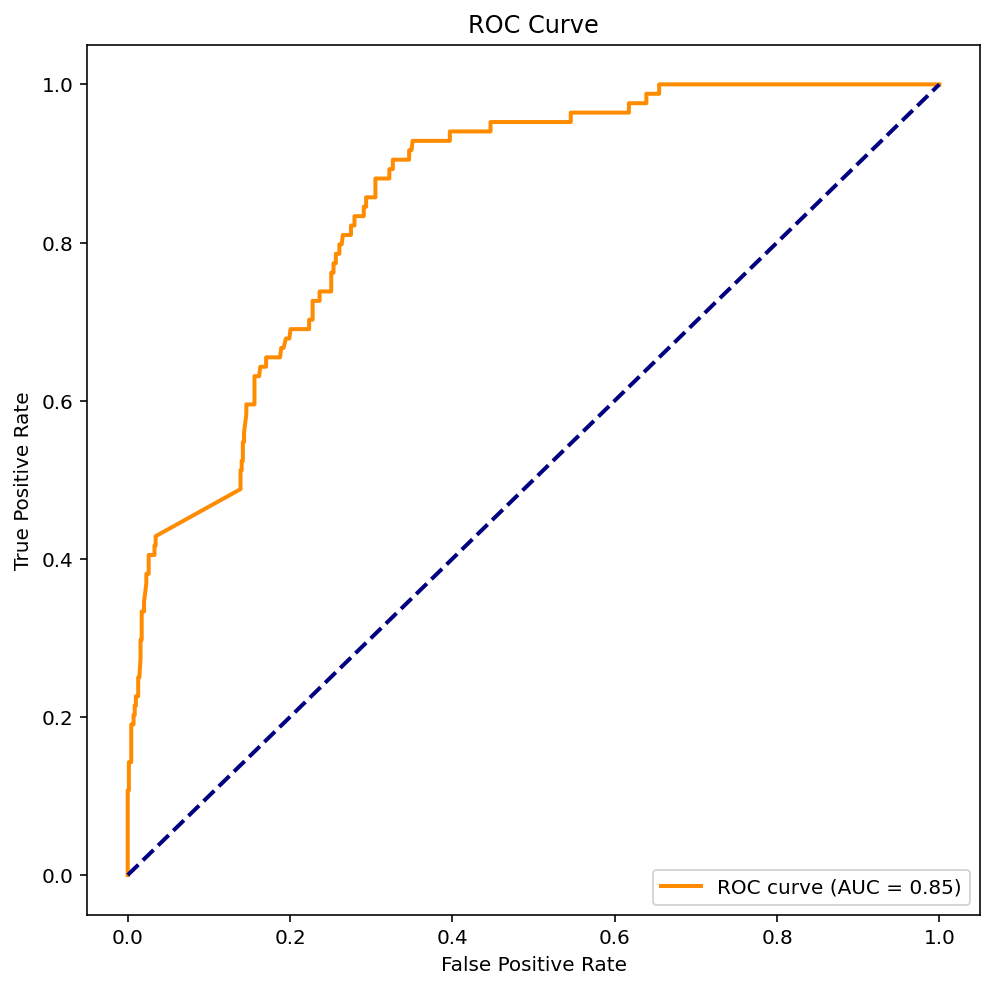

In [23]:
ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

4/4 [==============================] - 1s 240ms/step


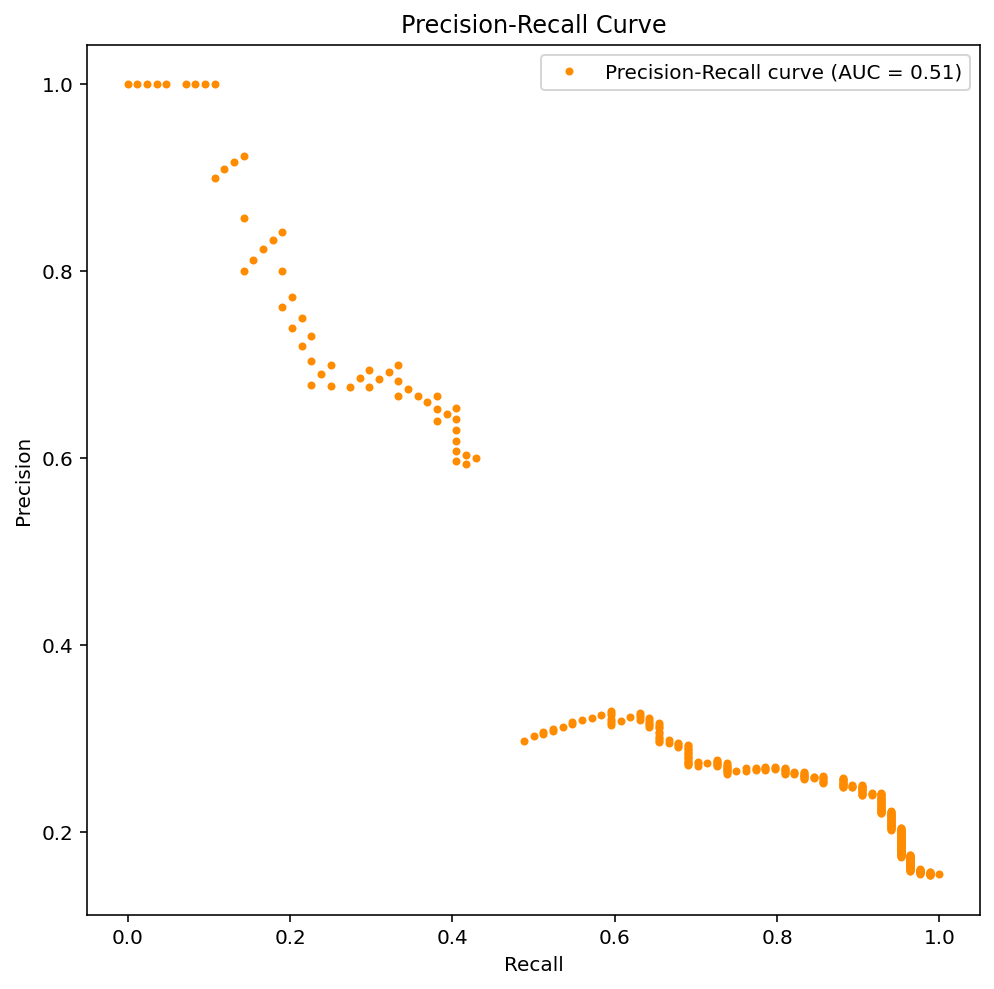

In [28]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)


precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, '.', color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

4/4 [==============================] - 1s 239ms/step


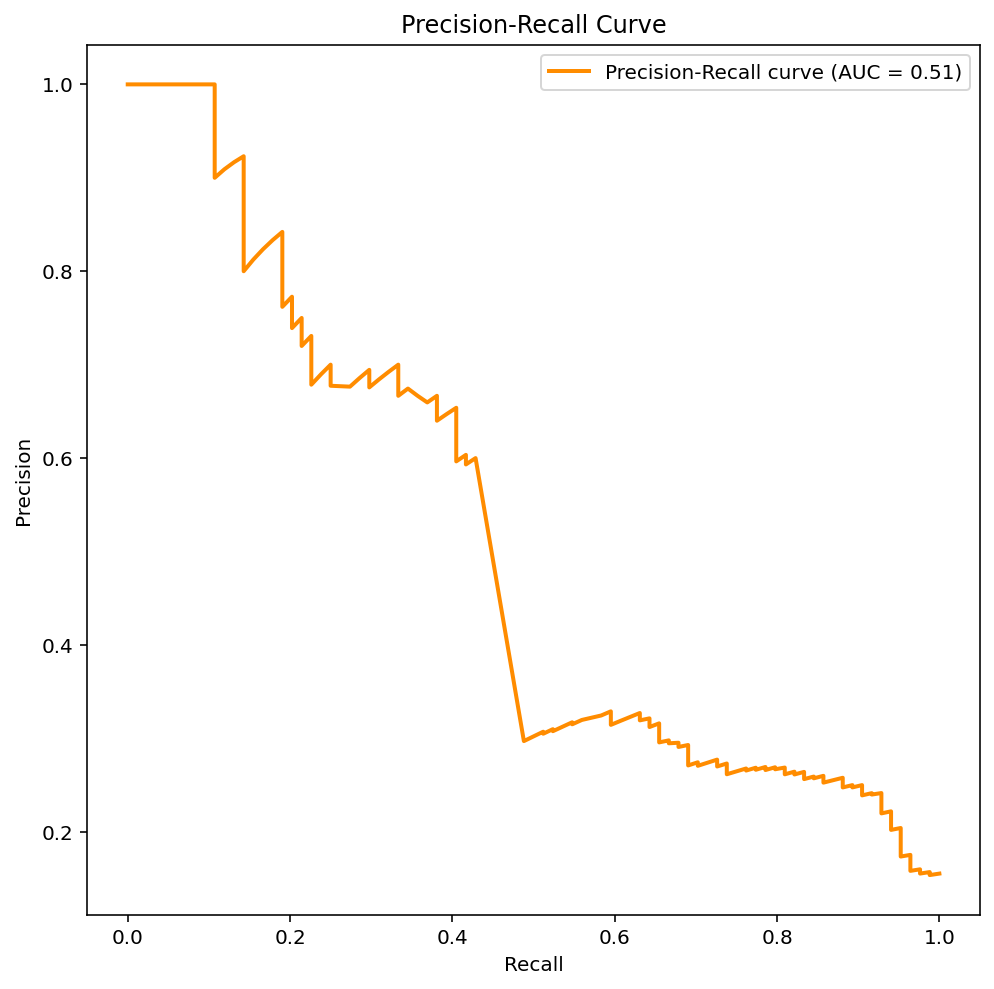

In [29]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

precision, recall, thresholds_pr = precision_recall_curve(y_true, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)

y_pred_optimal = (y_prob >= 0.3).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_optimal)
conf_matrix


4/4 [==============================] - 2s 549ms/step


array([[570, 128],
       [ 29,  55]])

/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_gpu_lukaliu.kernel.lukaliu.3339892979966.14b334fb371

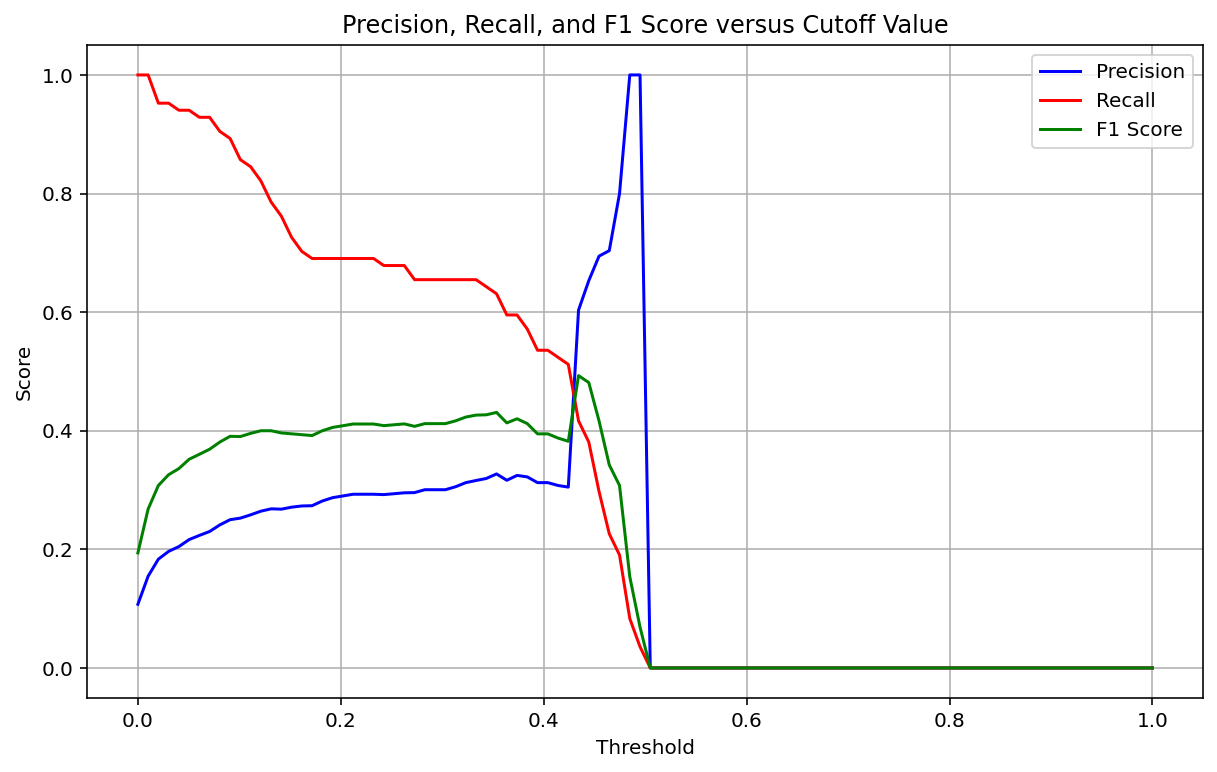

In [33]:

thresholds = np.linspace(0, 1, 100)
precision_scores = [precision_score(y_true, y_prob > threshold) for threshold in thresholds]
recall_scores = [recall_score(y_true, y_prob > threshold) for threshold in thresholds]
f1_scores = [f1_score(y_true, y_prob > threshold) for threshold in thresholds]

# Plot precision, recall, and F1 score versus cutoff value
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision', color='blue')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.plot(thresholds, f1_scores, label='F1 Score', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score versus Cutoff Value')
plt.legend()
plt.grid(True)
plt.show()


In [34]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score

ds_r = val_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)


precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

# Find the threshold that maximizes recall
optimal_threshold = thresholds[np.argmax(recall)]

# Apply the threshold to the predicted probabilities
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Calculate confusion matrix for the optimal threshold
conf_matrix = confusion_matrix(y_true, y_pred_optimal)

# Calculate recall for the optimal threshold
optimal_recall = recall_score(y_true, y_pred_optimal)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Optimal Recall: {optimal_recall}")



4/4 [==============================] - 1s 239ms/step
Optimal Threshold: 0.010136629454791546
Confusion Matrix:
[[241 457]
 [  0  84]]
Optimal Recall: 1.0


In [35]:
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_true, y_pred_optimal)
precision = precision_score(y_true, y_pred_optimal)

print(f"Recall: {recall}")
print(f"Precision: {precision}")

Recall: 1.0
Precision: 0.15526802218114602


# Testing evaluation

In [36]:
ds_r = test_ds_r

y_true = []
for x, y in ds_r:
    y_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_true = np.array(y_true)
y_prob = model.predict(ds_r)


precision, recall, thresholds = precision_recall_curve(y_true, y_prob)


# Apply the threshold to the predicted probabilities
y_pred_optimal = (y_prob >= 0.013279).astype(int)

# Calculate confusion matrix for the optimal threshold
conf_matrix = confusion_matrix(y_true, y_pred_optimal)

# Calculate recall for the optimal threshold
optimal_recall = recall_score(y_true, y_pred_optimal)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Optimal Recall: {optimal_recall}")



10/10 [==============================] - 3s 317ms/step
Optimal Threshold: 0.010136629454791546
Confusion Matrix:
[[ 439 1500]
 [  14  533]]
Optimal Recall: 0.9744058500914077


In [37]:
recall = recall_score(y_true, y_pred_optimal)
precision = precision_score(y_true, y_pred_optimal)

print(f"Recall: {recall}")
print(f"Precision: {precision}")

Recall: 0.9744058500914077
Precision: 0.2621741269060502


# save and load model

In [ ]:
# model.save('tf_rand_val_nn_v1.keras')

In [ ]:
!zip -r tf_rand_val_nn_v1.zip tf_rand_val_nn_v1

  adding: tf_rand_val_nn_v1/ (stored 0%)
  adding: tf_rand_val_nn_v1/saved_model.pb (deflated 94%)
  adding: tf_rand_val_nn_v1/fingerprint.pb (stored 0%)
  adding: tf_rand_val_nn_v1/variables/ (stored 0%)
  adding: tf_rand_val_nn_v1/variables/variables.index (deflated 23%)
  adding: tf_rand_val_nn_v1/variables/variables.data-00000-of-00001 (deflated 15%)
  adding: tf_rand_val_nn_v1/assets/ (stored 0%)
  adding: tf_rand_val_nn_v1/keras_metadata.pb (deflated 97%)


In [ ]:
!ls -lh

total 14M
lrwxrwxrwx  1 nogroup nogroup   141 Feb 27 22:31 alloc -> /export/hda3/borglet/remote_hdd_fs_dirs/colab_kernel_brain_frameworks_cpu_lukaliu.kernel_alloc.lukaliu.0.6168970077126.14b334fb3717c109/mount
drwxr-xr-x  2 nogroup nogroup  4.0K Feb 27 22:31 borg_generated_files
lrwxrwxrwx  1 nogroup nogroup   205 Feb 27 22:31 ctl_model_mpm -> /export/hda3/borglet/remote_package_fs_dirs/colab_kernel_brain_frameworks_cpu_lukaliu.kernel.ctl_model_mpm_v1-d48ecf98_fa4faa5a_78117269_bbec0ab0_d0822a7e.2e993e59b8097991.lukaliu.6168970085422/mount_point
drwx------  2 lukaliu 83689654   40 Feb 27 22:31 dev_shm
lrwxrwxrwx  1 nogroup nogroup   212 Feb 27 22:31 doc_langid_model_mpm -> /export/hda3/borglet/remote_package_fs_dirs/colab_kernel_brain_frameworks_cpu_lukaliu.kernel.doc_langid_model_mpm_v1-71a1a849_f4612f3c_566c5237_17295952_0fb0aa6b.84a273def24a307a.lukaliu.6168970085426/mount_point
lrwxrwxrwx  1 nogroup nogroup   200 Feb 27 22:31 gqui_pkg -> /export/hda3/borglet/remote_package_fs_dirs/

In [ ]:
%download_file tf_rand_val_nn_v1.zip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model 2 with date cutoff

In [ ]:
cutoff_date = '2022-06-01'
cutoff_date_2 = '2022-02-15'
train = final_data[final_data['date_time'] < cutoff_date_2].drop(columns=['date_time', 'is_avy_obs'])
val = final_data[(final_data['date_time'] >= cutoff_date_2) & (final_data['date_time'] < cutoff_date) ].drop(columns=['date_time', 'is_avy_obs'])
test = final_data[final_data['date_time'] >= cutoff_date].drop(columns=['date_time', 'is_avy_obs'])


print(train.shape)
print(val.shape)
print(test.shape)


(3107, 3158)
(799, 3158)
(2486, 3158)


In [ ]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
all_inputs_num_vars_norm = []
encoded_features_num_vars_norm = []

# Numerical features.
for header in feature_dict["num_vars_norm"]:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs_num_vars_norm.append(numeric_col)
  encoded_features_num_vars_norm.append(encoded_numeric_col)

In [ ]:
all_inputs_cat_vars_str = []
encoded_features_cat_vars_str= []

for header in feature_dict["cat_vars_str"]:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs_cat_vars_str.append(categorical_col)
  encoded_features_cat_vars_str.append(encoded_categorical_col)

In [ ]:
all_inputs_cat_vars_num = []
encoded_features_cat_vars_num= []


for header in feature_dict["cat_vars_num"]:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int32',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs_cat_vars_num.append(categorical_col)
  encoded_features_cat_vars_num.append(encoded_categorical_col)

In [ ]:
all_inputs_num_vars = []
encoded_features_num_vars= []

for num_var in feature_dict['num_vars']:
    input_layer = tf.keras.Input(shape=(1,), name=num_var)
    all_inputs_num_vars.append(input_layer)
    encoded_features_num_vars.append(input_layer)

In [ ]:
encoded_features = encoded_features_num_vars_norm + encoded_features_cat_vars_str + encoded_features_cat_vars_num + encoded_features_num_vars
all_inputs = all_inputs_num_vars_norm + all_inputs_cat_vars_str + all_inputs_cat_vars_num + all_inputs_num_vars

In [ ]:
# kernel_regularizer=tf.keras.regularizers.l2(0.01) is added to the dense layer,
# providing L2 regularization with a regularization strength of 0.01.
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
# x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
hisotry = model.fit(train_ds,
          validation_data=val_ds,
          epochs=40,  # You can set the number of epochs based on your requirements
          callbacks=[early_stopping])

Epoch 1/40


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 69s 3s/step - loss: 0.4245 - precision_21: 0.2083 - recall_21: 0.0133 - val_loss: 0.2908 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00
Epoch 2/40
13/13 [==============================] - 12s 554ms/step - loss: 0.3588 - precision_21: 0.1250 - recall_21: 0.0027 - val_loss: 0.2692 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 11s 549ms/step - loss: 0.3502 - precision_21: 0.6522 - recall_21: 0.1194 - val_loss: 0.2591 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 12s 569ms/step - loss: 0.3454 - precision_21: 0.5449 - recall_21: 0.2255 - val_loss: 0.2525 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 12s 553ms/step - loss: 0.3342 - precision_21: 0.6721 - recall_21: 0.1088 - val_loss: 0.2467 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00

In [ ]:
model.evaluate(test_ds)

10/10 [==============================] - 6s 624ms/step - loss: 0.5319 - precision_21: 0.0000e+00 - recall_21: 0.0000e+00


[0.5318851470947266, 0.0, 0.0]

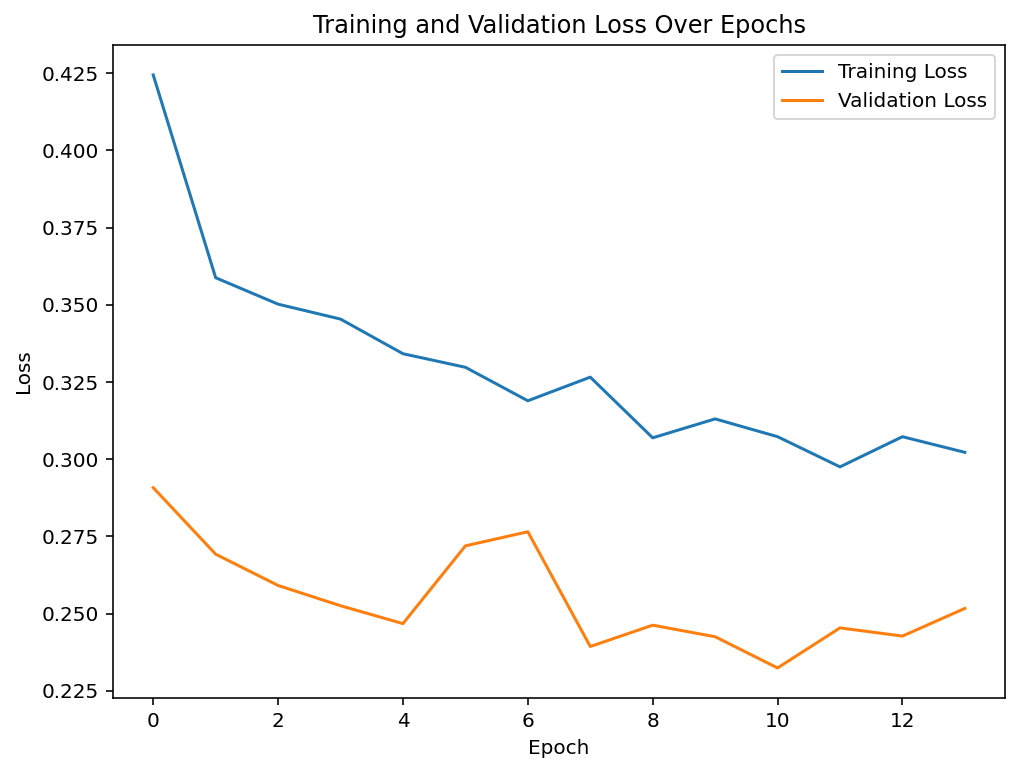

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(hisotry.history['loss'], label='Training Loss')
plt.plot(hisotry.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

4/4 [==============================] - 24s 436ms/step


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


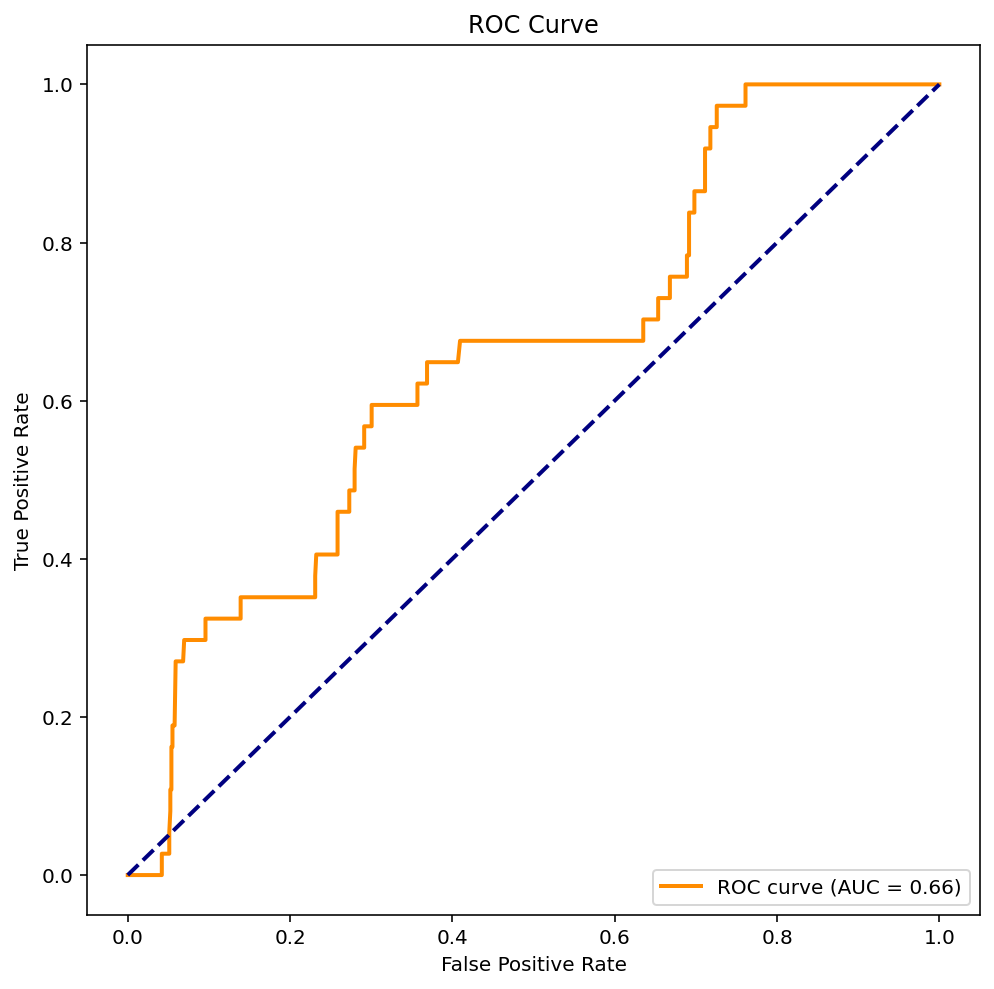

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


y_val_true = []
for x, y in val_ds:
    y_val_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_val_true = np.array(y_val_true)
y_val_prob = model.predict(val_ds)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Model 3

In [ ]:
# kernel_regularizer=tf.keras.regularizers.l2(0.01) is added to the dense layer,
# providing L2 regularization with a regularization strength of 0.01.
all_features = tf.keras.layers.concatenate(encoded_features)
# x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics= [tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
hisotry = model.fit(train_ds,
          validation_data=val_ds,
          epochs=40,  # You can set the number of epochs based on your requirements
          callbacks=[early_stopping])

Epoch 1/40


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 70s 2s/step - loss: 1.3405 - precision_22: 0.1380 - recall_22: 0.1194 - val_loss: 0.7363 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 2/40
13/13 [==============================] - 12s 555ms/step - loss: 0.8488 - precision_22: 0.2830 - recall_22: 0.0398 - val_loss: 0.6861 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 12s 557ms/step - loss: 0.7498 - precision_22: 0.5333 - recall_22: 0.0424 - val_loss: 0.6146 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 12s 566ms/step - loss: 0.7000 - precision_22: 0.6585 - recall_22: 0.0716 - val_loss: 0.5747 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 12s 576ms/step - loss: 0.6549 - precision_22: 0.6000 - recall_22: 0.0477 - val_loss: 0.5473 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00

In [ ]:
model.evaluate(test_ds)

10/10 [==============================] - 7s 651ms/step - loss: 0.5663 - precision_22: 0.0000e+00 - recall_22: 0.0000e+00


[0.5663472414016724, 0.0, 0.0]

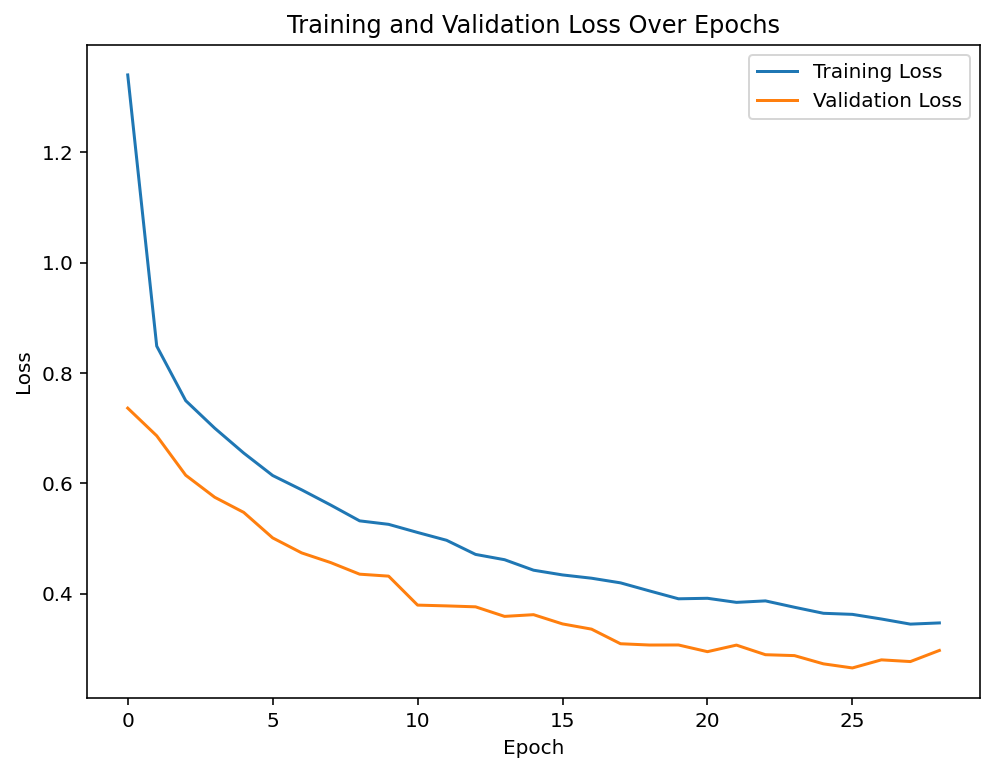

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(hisotry.history['loss'], label='Training Loss')
plt.plot(hisotry.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

4/4 [==============================] - 25s 506ms/step


/export/hda3/borglet/remote_hdd_fs_dirs/0.colab_kernel_brain_frameworks_cpu_lukaliu.kernel.lukaliu.6168970085477.14b334fb3717c109/mount/server/ml_notebook.runfiles/google3/third_party/py/tf_keras/engine/functional.py:641: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


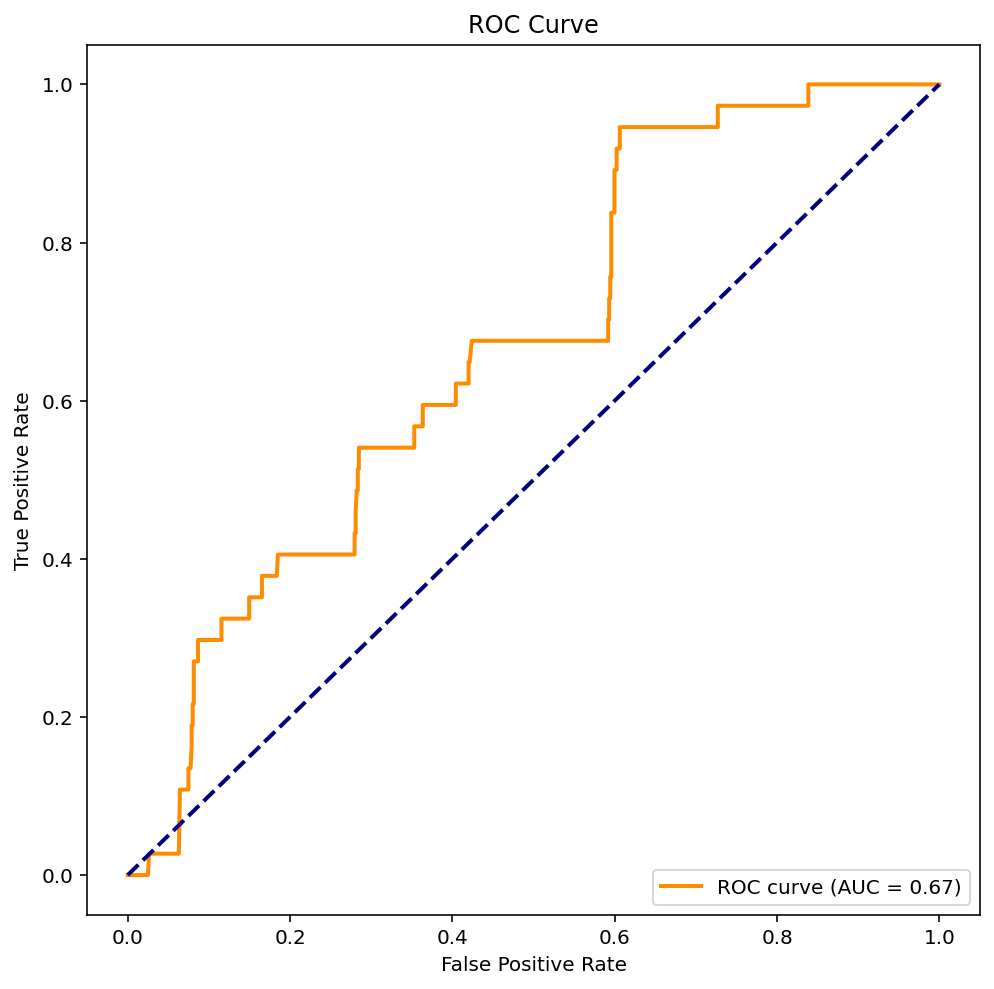

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


y_val_true = []
for x, y in val_ds:
    y_val_true.extend(y.numpy().flatten())

# Convert the target values to a NumPy array
y_val_true = np.array(y_val_true)
y_val_prob = model.predict(val_ds)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_true, y_val_prob)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
